In [2]:
import os
import cv2
import time
import json
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
import configparser

In [4]:
config = configparser.ConfigParser()

In [5]:
config.read('../../jedi-web/app.cfg')

['../../jedi-web/app.cfg']

In [6]:
config.sections()

['CATS', 'DOGS', 'TEXT']

In [7]:
config['DEFAULT']['META_PATH']

'/home/arun/research/projects/crowdsourcing/kdd-2019/data/animal_breed_sdm/nameMapping_fullInfo_flipped0.2.mat'

In [8]:
# get the metadata
meta_path = "/home/arun/research/projects/crowdsourcing/kdd-2019/data/animal_breed_sdm/nameMapping_fullInfo_flipped0.2.mat"
data = sio.loadmat(meta_path)['nameMapping']
rows = []
for d in data:
    rows.append([x[0] for x in d.tolist()])
df = pd.DataFrame(rows, columns=['img_name','common_name','dataset','train_test','class','is_flipped'])
df.head(3)

,img_name,common_name,dataset,train_test,class,is_flipped
0,017b48ee703065873bb525dab52b0ed8_resize.jpg,DH0KCZVBYAJLREPQ293S61IN5TFMU4O7WXG8_0001,horse,test,wild,[]
1,02cfc4cbbcf0eb8a0de91c8c2fde9ee3_resize.jpg,E6358ALYVHDQPSJ21C7MWZ09INTKOR4XFUGB_0002,horse,test,domestic,[]
2,033b7c459edd347e83e7f6d7dec1dfa1_resize.jpg,62PRESG3JZU8COX5TK47Q1ABVNFD90MYWILH_0003,cat,train,wild,nope


# Interactive teaching with ANIMAL images

__1st step__: show the original image to the worker...
K1ZWQLMO259C0HAVRFIB4US6D83GN7YEXTPJ_0006.jpg 



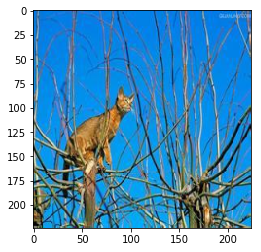

__2nd step__: ask the worker to provide initial label (domestic OR wild)... 

__3rd step__: show the explanations (domestic/wild) and the confidences (domestic/wild) to the worker...


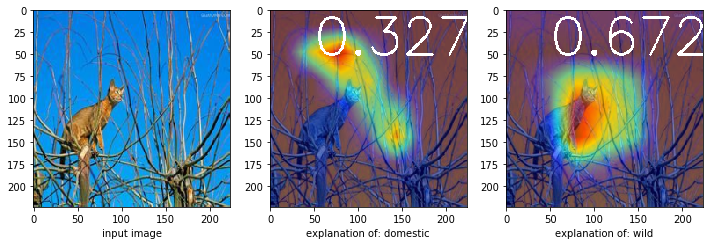

__4-th step__: let the worker choose her feedback: (1). y_domestic OR y_wild; (2). exp_domestic OR exp_wild...

__5-th step__: verify the confidence of the worker's answer.
 E.g., if the worker choose y_domestic (rejecting the high probability prediction of y_wild) but trust exp_wild instead...


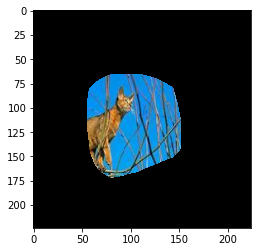

Ask the worker: can you still recognize the masked image as 'y_domestic'(the answer that the worker provided)?
 If the worker still convinced that he will give label of 'y_domestic',  we will add '+1' to the label set of the item, otherwise, we won't save the label...


In [9]:
datasets = df['dataset'].tolist()
index_cat = [i for i,s in enumerate(datasets) if s == 'cat']
filenames = df['common_name'].tolist()
filenames_cat = [filenames[i] for i in index_cat]
file_path = "/home/arun/Dropbox (ASU)/code_for_Arun/finetune/animal_breed_sdm/data_cat_flipped0.2/all/"
exp_path = "/home/arun/Dropbox (ASU)/code_for_Arun/interpretable_difficulty_api/results_resnet34_cat_flipped0.2/results_all_puttext/"
pred_class = ["domestic", "wild"]

pred_prob_path = "/home/arun/Dropbox (ASU)/code_for_Arun/gradCAM/results_resnet34_cat_flipped0.2/results_all_puttext"
with open(os.path.join(pred_prob_path , 'prob_all.json'), 'r') as f:
    pred_prob_all = json.load(f)

def applymask(img, exp, thresh):
    exp_masked = exp >= thresh * 255
    return img * exp_masked
    
# steps of interactive teaching
for idx, filename in enumerate(filenames_cat):
    if idx != 2:
        continue
    ###### step 1 ######
    imgfile = filename + ".jpg"
    print('__1st step__: show the original image to the worker...')
    print(imgfile, '\n')
    img = cv2.imread(file_path + imgfile)[..., ::-1]
    img_resize = cv2.resize(img, (224, 224))
    plt.imshow(img_resize)
    plt.show()
    
    ##### step 2 ######
    print('__2nd step__: ask the worker to provide initial label (domestic OR wild)... \n')
    
    ###### step 3 ######
    print('__3rd step__: show the explanations (domestic/wild) and the confidences (domestic/wild) to the worker...')
    plt.figure(figsize=(12,16))
    for i in range(len(pred_class) + 1):
        plt.subplot(1,3,i+1)        
        if i == 0:
            plt.imshow(img_resize)
            plt.xlabel('input image')
        else:
            expname = filename + "_" + pred_class[i-1] + ".png"
            exp = cv2.imread(exp_path + expname, 1)[..., ::-1]
            plt.imshow(exp)
            plt.xlabel('explanation of: ' + pred_class[i-1])
    plt.show()    
    
    ###### step 4 ######
    print('__4-th step__: let the worker choose her feedback: (1). y_domestic OR y_wild; (2). exp_domestic OR exp_wild...\n')
    
    ###### step 5 ######
    print("__5-th step__: verify the confidence of the worker\'s answer.\n",  
          "E.g., if the worker choose y_domestic (rejecting the high probability prediction of y_wild)",
          "but trust exp_wild instead...")
    pred_prob = pred_prob_all[imgfile][::-1]
    exp_threshold = pred_prob[0]
    exp_heatmap_name = filename + "_" + pred_class[1] + "_heatmap.png"
    exp_heatmap = cv2.imread(exp_path + exp_heatmap_name, 1)
#     exp_heatmap = cv2.imread(exp_path + exp_heatmap_name, 0)
#     fig = plt.imshow(exp_heatmap, cmap='jet')
#     plt.xlabel('explanation heatmap of: ' + pred_class[1])
#     plt.colorbar(fig)
#     plt.show()
    img_masked = applymask(img_resize, exp_heatmap, exp_threshold)
    plt.imshow(img_masked)
    plt.show()
    print("Ask the worker: can you still recognize the masked image",
          "as \'y_domestic\'(the answer that the worker provided)?\n",
          "If the worker still convinced that he will give label of \'y_domestic\', ",
          "we will add \'+1\' to the label set of the item, otherwise, we won\'t save the label...")

# Interactive teaching with 20NG documents

In [10]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from lime.lime_text import LimeTextExplainer

categories = ['comp.os.ms-windows.misc', 'sci.crypt']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# get the explanation of text  10 words explanation, 
#                              10 words explanation on positive class [sci]
#                              10 words explanation on neg class [comp]
# it should be noticed, in model training:
#               positive class is [comp], negative class is [sci], which is opposite in explanation

exp_path_10 = "/home/arun/Dropbox (ASU)/code_for_Arun/text_data/comp_vs_sci_flipped0.3/explanation_train_10.pickle"
exp_10 = pickle.load( open(exp_path_10, "rb" ) )

exp_path_10_pos = "/home/arun/Dropbox (ASU)/code_for_Arun/text_data/comp_vs_sci_flipped0.3/explanation_train_10_pos.pickle"
exp_10_pos = pickle.load( open(exp_path_10_pos, "rb" ) )

exp_path_10_neg = "/home/arun/Dropbox (ASU)/code_for_Arun/text_data/comp_vs_sci_flipped0.3/explanation_train_10_neg.pickle"
exp_10_neg = pickle.load( open(exp_path_10_neg, "rb" ) )

In [16]:
categories = ['comp.os.ms-windows.misc', 'sci.crypt']
class_names = ['comp', 'sci']

for idx, exp_obj in enumerate(exp_10):
    if idx != 3:
        continue
#     print('GT label is:', categories[newsgroups_train.target[idx]])
    
    ###### step 1 ######
    print('__1st step__: show the original text document to the worker...')
    print(newsgroups_train.data[idx])
    
    ###### step 2 ######
    print('__2nd step__: ask the worker to provide initial label (sci.crypt[+1] OR comp.os.ms-windows.misc[-1])... \n')
    
    ###### step 3 ######
    print('__3rd step__: show the confidence (sci/comp) and explanations (sci/comp) to the worker...')
    exp = exp_obj.as_list()
    exp_value = [v for (k, v) in exp]
    exp_value_abs = np.array([abs(v) for v in exp_value])
    exp_value_abs_normalized = exp_value_abs / sum(exp_value_abs)
#     print(exp_value_abs_normalized)
#     print(np.cumsum(exp_value_abs_normalized))
#     print(np.cumsum(exp_value_abs_normalized[::-1]))
    exp_obj.show_in_notebook(text=True)
    
    ###### step 4 ######
    print('__4-th step__: let the worker choose her feedback: y_sci OR y_comp. \n')
    
    ###### step 5 ######
    print("__5-th step__: verify the confidence of the worker\'s answer.\n",  
          "E.g., if the worker choose y_comp (accepting the high probability prediction of y_comp)")
    exp_obj = exp_10_neg[idx]
    exp = exp_obj.as_list()
    exp_value = [v for (k, v) in exp]
    exp_value_abs = np.array([abs(v) for v in exp_value])
    exp_value_abs_normalized = exp_value_abs / sum(exp_value_abs)
#     print(exp_value_abs_normalized)
    exp_obj.show_in_notebook(text=True)
    
    exp_obj.save_to_file('/tmp/test_file_{}.html'.format(idx))
    
    print("Ask the worker: can you still classify the new highlighted document",
          "as \'y_comp\'(the answer that the worker provided)?\n",
          "If the worker still convinced that he will give label of \'y_comp\' [which is -1 in explanation], ",
          "we will add \'+1\' [in model training, it is the class of \'comp\'] to the label set of the item, "
          "otherwise, we won\'t save the label...")

__1st step__: show the original text document to the worker...
From: kuehnel@rvs.uni-hannover.de (Stefan Kuehnel, SWL)
Subject: Re: NT Questions
Reply-To: kuehnel@rvs.uni-hannover.de
Organization: RVS, Universitaet Hannover, Germany
Lines: 38

In article 5802@news.yale.edu, adriene_nazaretian@qm.yale.edu (Adriene Nazaretian) writes:
> In article <1993Mar26.020427.29119@samba.oit.unc.edu>, tclark@med.unc.edu (Thomas B. Clark) says

[...]

> >2.  Is the driver support as seamless as program support?
> >e.g., Will my Soundblaster, scanner, CD-Rom, tape backup
> >continue to work even if there are no specific NT drivers?
> >
> There is a hardware compatibility guide to answer these questions.
> There are many drivers for CD Rom and there are MIDI and other
   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
> sound drivers installed, I dont do a lot with sound digitizing on this
> platform, but recall seeing items for their configuration in the Control
> Panel Applet.  There is built in support for tape b

__4-th step__: let the worker choose her feedback: y_sci OR y_comp. 

__5-th step__: verify the confidence of the worker's answer.
 E.g., if the worker choose y_comp (accepting the high probability prediction of y_comp)


Ask the worker: can you still classify the new highlighted document as 'y_comp'(the answer that the worker provided)?
 If the worker still convinced that he will give label of 'y_comp' [which is -1 in explanation],  we will add '+1' [in model training, it is the class of 'comp'] to the label set of the item, otherwise, we won't save the label...


In [18]:
categories = ['comp.os.ms-windows.misc', 'sci.crypt']
class_names = ['comp', 'sci']

for idx, exp_obj in enumerate(exp_10):
    exp = exp_obj.as_list()
    exp_value = [v for (k, v) in exp]
    exp_value_abs = np.array([abs(v) for v in exp_value])
    exp_value_abs_normalized = exp_value_abs / sum(exp_value_abs)
    exp_obj.save_to_file('/home/arun/research/projects/crowdsourcing/kdd-2019/code/jedi-web/templates/txt/expl/expl_{}.html'.format(idx))